In [1]:
# Copy of the tutorial's PDF

# Importing libraries
import pandas as pd
from numpy import *
import yfinance as yf
from scipy.stats import norm
# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate
# Set max row to 300
pd.set_option('display.max_rows', 300)

# Black Scholes Model

## Options Object

In [2]:
class BS:
    """
    This is a class for Options contract for pricing European options on stocks␣
    ,→without dividends.
    Attributes:
    spot : int or float
    strike : int or float
    rate : float
    dte : int or float [days to expiration in number of years]
    volatility : float
    """

    def __init__(self, spot, strike, rate, dte, volatility):
        # Spot Price
        self.spot = spot
        # Option Strike
        self.strike = strike
        # Interest Rate
        self.rate = rate
        # Days To Expiration
        self.dte = dte
        # Volatility
        self.volatility = volatility
        # Utility
        self._a_ = (
            self.volatility * self.dte**0.5
        )  # normalize daily volatility to DtE time length
        if self.strike == 0:
            raise ZeroDivisionError("The strike price cannot be zero")
        else:
            self._d1_ = (
                log(self.spot / self.strike) + (self.rate + (self.volatility**2) / 2) * self.dte
            ) / self._a_
            self._d2_ = self._d1_ - self._a_
            self._b_ = e ** -(self.rate * self.dte)

        # The __dict__ attribute
        """
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        """
        for i in [
            "callPrice",
            "putPrice",
            "callDelta",
            "putDelta",
            "callTheta",
            "putTheta",
            "callRho",
            "putRho",
            "vega",
            "gamma",
        ]:
            self.__dict__[i] = None

        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()

    # Option Price
    def _price(self):
        """Returns the option price: [Call price, Put price]"""

        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e ** (
                -self.rate * self.dte
            ) * norm.cdf(self._d2_)
            put = self.strike * e ** (-self.rate * self.dte) * norm.cdf(
                -self._d2_
            ) - self.spot * norm.cdf(-self._d1_)
            return [call, put]

    # Option Delta
    def _delta(self):
        """Returns the option delta: [Call delta, Put delta]"""
        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]

    # Option Gamma
    def _gamma(self):
        """Returns the option gamma"""
        return norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        """Returns the option vega"""
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100

    # Option Theta
    def _theta(self):
        """Returns the option theta: [Call theta, Put theta]"""
        a = self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5)
        b = self.rate * self.strike * self._b_ * norm.cdf(self._d2_)
        call = -a - b
        put = -a + b
        return [call / 365, put / 365]

    # Option Rho
    def _rho(self):
        """Returns the option rho: [Call rho, Put rho]"""
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100
        return [call, put]

In [3]:
# Initialize option
option = BS(100, 100, 0.05, 1, 0.2)
header = ["Option Price", "Delta", "Gamma", "Theta", "Vega", "Rho"]
table = [
    [
        option.callPrice,
        option.callDelta,
        option.gamma,
        option.callTheta,
        option.vega,
        option.callRho,
    ]
]
pd.DataFrame(table, columns=header)

,Option Price,Delta,Gamma,Theta,Vega,Rho
0,10.450584,0.636831,0.018762,-0.017573,0.37524,0.532325


In [4]:
defaults = dict(spot=100, rate=0.05, dte=1.0, volatility=0.2)

In [5]:
# strangle
leg1 = BS(strike=110, **defaults)
leg2 = BS(strike=90, **defaults)

leg1.callPrice + leg2.putPrice, leg1.callDelta + leg2.putDelta

(8.350184743204505, 0.25935099141266815)

In [6]:
# ironfly
leg1 = BS(strike=100, **defaults)
leg2 = BS(strike=110, **defaults)
leg3 = BS(strike=90, **defaults)

leg1.callPrice + leg1.putPrice - leg2.callPrice - leg3.putPrice

7.673924851238031

# SPY Option

In [7]:
spy = yf.Ticker('SPY')
expiration = spy.options


In [8]:
from datetime import datetime
dt_from = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
dt_to = pd.to_datetime(expiration[14]).to_pydatetime()

dt_from, dt_to

(datetime.datetime(2023, 8, 21, 0, 0), datetime.datetime(2023, 10, 20, 0, 0))

In [9]:
dte = 7/252 # trading days per year in US
dte

0.027777777777777776

In [11]:
# Get SPY option chain
spy = yf.Ticker('SPY')
options = spy.option_chain(dt_to.date().isoformat())

In [12]:
contract_symbol = f"SPY{dt_to.strftime('%y%m%d')}C00450000"

options.calls.set_index("contractSymbol").loc[contract_symbol]

lastTradeDate        2023-08-21 18:19:39+00:00
strike                                   450.0
lastPrice                                 5.69
bid                                       5.68
ask                                       5.69
change                                    0.38
percentChange                         7.156311
volume                                  2167.0
openInterest                             35611
impliedVolatility                     0.145455
inTheMoney                               False
contractSize                           REGULAR
currency                                   USD
Name: SPY231020C00450000, dtype: object

In [13]:
# August 2023 450 SPY call option price
spot = 447; strike = 450; rate = 0.0; dte = dte; vol = 0.1328
spy_opt = BS(spot,strike,rate,dte,vol)
print(f'Option Price of {contract_symbol} with BS Model is:\n{spy_opt.callPrice:0.4f}')

Option Price of SPY231020C00450000 with BS Model is:
2.6396


In [14]:
# Verify the options output
options.calls.head(2)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY231020C00150000,2023-08-17 15:51:59+00:00,150.0,289.79,288.66,289.39,0.0,0.0,1.0,18,1.234379,True,REGULAR,USD
1,SPY231020C00160000,2023-07-18 14:18:07+00:00,160.0,293.00,276.47,277.39,0.0,0.0,2.0,2,0.000010,True,REGULAR,USD


## Calls

In [15]:
# Filter calls for strike at or above 450
df = options.calls[(options.calls["strike"] >= 400) & (options.calls["strike"] <= 500)]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame(
    {"Strike": df["strike"], "Price": df["lastPrice"], "ImpVol": df["impliedVolatility"]}
)
# Derive greeks and assign to dataframe as columns
df["Delta"] = df["Gamma"] = df["Vega"] = df["Theta"] = 0.0

for i in range(len(df)):
    df["Delta"].iloc[i] = BS(spot, df["Strike"].iloc[i], rate, dte, df["ImpVol"].iloc[i]).callDelta
    df["Gamma"].iloc[i] = BS(spot, df["Strike"].iloc[i], rate, dte, df["ImpVol"].iloc[i]).gamma
    df["Vega"].iloc[i] = BS(spot, df["Strike"].iloc[i], rate, dte, df["ImpVol"].iloc[i]).vega
    df["Theta"].iloc[i] = BS(spot, df["Strike"].iloc[i], rate, dte, df["ImpVol"].iloc[i]).callTheta

# Check output
df.head()

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,400.0,43.00,0.264991,0.994418,0.000808,0.011882,-0.015527
1,401.0,46.04,0.261543,0.994016,0.000871,0.012637,-0.016299
2,402.0,39.79,0.259468,0.993343,0.000964,0.013888,-0.017770
3,404.0,51.16,0.253517,0.992130,0.001144,0.016096,-0.020124
4,405.0,36.13,0.251869,0.991143,0.001277,0.017856,-0.022179


### Visualize Data

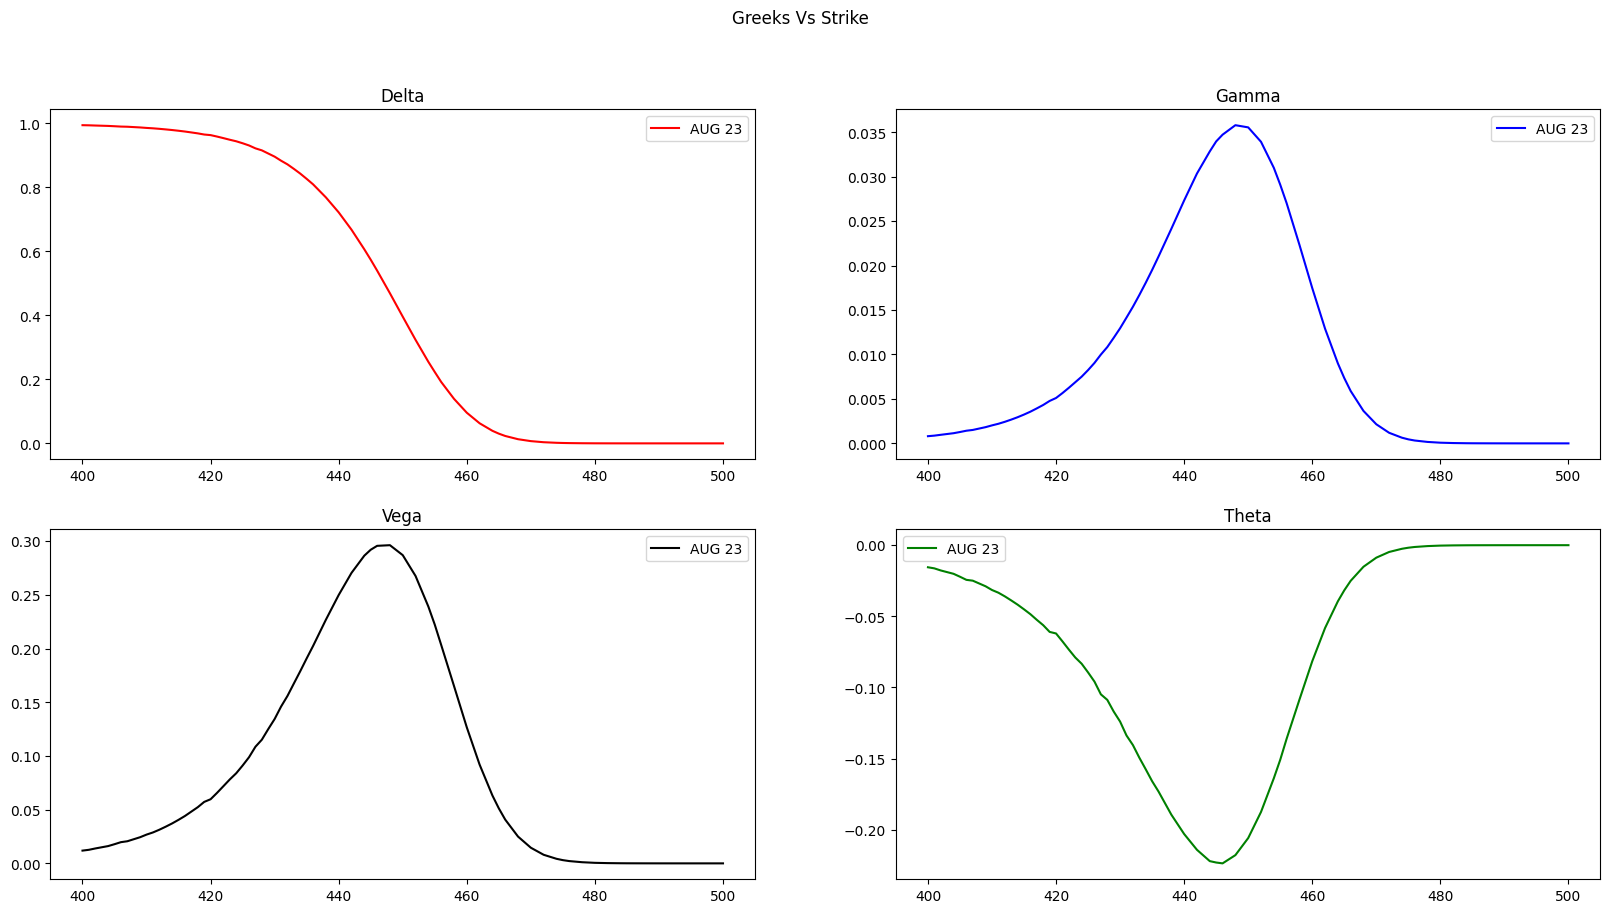

In [16]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='AUG 23')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='AUG 23')
ax[1,0].plot(df['Strike'], df['Vega'], color='k', label='AUG 23')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='AUG 23')

# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')

plt.show()

## Puts

In [17]:
# Filter calls for strike at or above 450
df = options.puts[(options.puts["strike"] >= 400) & (options.puts["strike"] <= 500)]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame(
    {"Strike": df["strike"], "Price": df["lastPrice"], "ImpVol": df["impliedVolatility"]}
)
# Derive greeks and assign to dataframe as columns
df["Delta"] = df["Gamma"] = df["Vega"] = df["Theta"] = 0.0

for i in range(len(df)):
    df["Delta"].iloc[i] = BS(spot, df["Strike"].iloc[i], rate, dte, df["ImpVol"].iloc[i]).putDelta
    df["Gamma"].iloc[i] = BS(spot, df["Strike"].iloc[i], rate, dte, df["ImpVol"].iloc[i]).gamma
    df["Vega"].iloc[i] = BS(spot, df["Strike"].iloc[i], rate, dte, df["ImpVol"].iloc[i]).vega
    df["Theta"].iloc[i] = BS(spot, df["Strike"].iloc[i], rate, dte, df["ImpVol"].iloc[i]).putTheta

# Check output
df.head()

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,400.0,2.34,0.202523,-0.000470,0.000111,0.001249,-0.001248
1,401.0,2.45,0.200753,-0.000552,0.000130,0.001452,-0.001437
2,402.0,2.49,0.198891,-0.000647,0.000152,0.001679,-0.001647
3,403.0,2.63,0.196480,-0.000735,0.000173,0.001889,-0.001830
4,404.0,2.92,0.195443,-0.000900,0.000210,0.002277,-0.002195


### Visualize Data

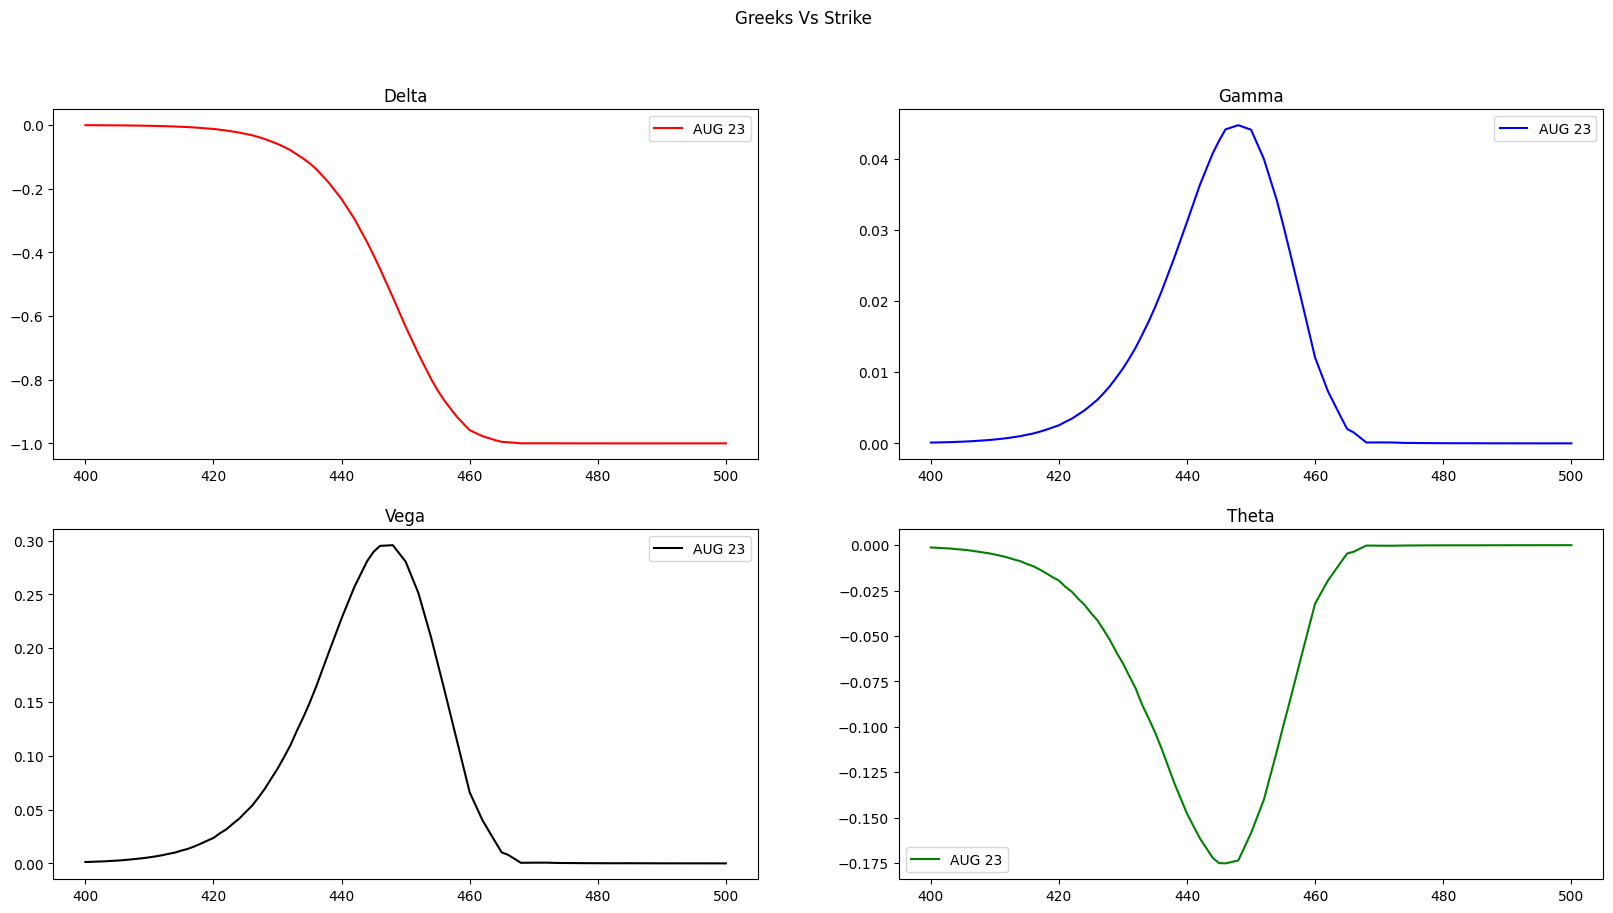

In [18]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='AUG 23')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='AUG 23')
ax[1,0].plot(df['Strike'], df['Vega'], color='k', label='AUG 23')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='AUG 23')

# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')

plt.show()